# BASEADO EM: MARATONA BEHIND THE CODE

## EXEMPLO DE USO NO KUBEFLOW

### Introdução

Em projetos de ciência de dados visando a construção de modelos de *machine learning*, ou aprendizado estatístico, é muito incomum que os dados iniciais estejam já no formato ideal para a construção de modelos. São necessários vários passos intermediários de pré-processamento de dados, como por exemplo a codificação de variáveis categóricas, normalização de variáveis numéricas, tratamento de dados faltantes, etc. A biblioteca **scikit-learn** -- uma das mais populares bibliotecas de código-aberto para *machine learning* no mundo -- possui diversas funções já integradas para a realização das transformações de dados mais utilizadas. Entretanto, em um fluxo comum de um modelo de aprendizado de máquina, é necessária a aplicação dessas transformações pelo menos duas vezes: a primeira vez para "treinar" o modelo, e depois novamente quando novos dados forem enviados como entrada para serem classificados por este modelo. 

Para facilitar o trabalho com esse tipo de fluxo, o scikit-learn possui também uma ferramenta chamada **Pipeline**, que nada mais é do que uma lista ordenada de transformações que devem ser aplicadas nos dados.


## ** ATENÇÃO **

Este notebook serve apenas um propósito educativo, você pode alterar o código como quiser e nada aqui será avaliado/pontuado.

A recomendação é que você experimente e teste diferentes algoritmos.

### Trabalhando com Pipelines do scikit-learn

In [33]:
# Primeiro, realizamos a instalação do scikit-learn versão 0.20.3, seaborn e do xgboost versão 0.71 no Kernel deste notebook
!pip install scikit-learn==0.20.3 --upgrade
!pip install seaborn --upgrade
!pip install xgboost==0.71 --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [34]:
# Em seguida iremos importar diversas bibliotecas que serão utilizadas:

# Pacote para trabalhar com JSON
import json

# Pacote para realizar requisições HTTP
import requests

# Pacote para exploração e análise de dados
import pandas as pd

# Pacote com métodos numéricos e representações matriciais
import numpy as np

# Pacote para construção de modelo baseado na técnica Gradient Boosting
import xgboost as xgb

# Pacotes do scikit-learn para pré-processamento de dados
# "SimpleImputer" é uma transformação para preencher valores faltantes em conjuntos de dados
from sklearn.impute import SimpleImputer

# Pacotes do scikit-learn para treinamento de modelos e construção de pipelines
# Método para separação de conjunto de dados em amostras de treino e teste
from sklearn.model_selection import train_test_split
# Método para criação de modelos baseados em árvores de decisão
from sklearn.tree import DecisionTreeClassifier
# Classe para a criação de uma pipeline de machine-learning
from sklearn.pipeline import Pipeline

# Pacotes do scikit-learn para avaliação de modelos
# Métodos para validação cruzada do modelo criado
from sklearn.model_selection import KFold, cross_validate

### Importando um .csv para o Kernel deste notebook [ALTERADO FONTE DADOS: CURSO_DW.CSV]

Primeiro iremos importar o dataset fornecido para o desafio, que já está incluso neste projeto!

Você pode realizar a importação dos dados de um arquivo .csv diretamente para o Kernel do notebook como um DataFrame da biblioteca Pandas, muito utilizada para a manipulação de dados em Python.

Para realizar a importação, inserir o código necessário para importação e leitura dos dados no arquivo .csv como um DataFrame Pandas.

In [35]:

# LE O DATASET COMO UM PANDAS DATAFRAME.
df_data_1 = pd.read_csv('curso_dw.csv')

df_data_1.head()

,MATRICULA,NOME,REPROVACOES_MAT_1,REPROVACOES_MAT_2,REPROVACOES_MAT_3,REPROVACOES_MAT_4,NOTA_MAT_1,NOTA_MAT_2,NOTA_MAT_3,NOTA_MAT_4,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL,INGLES_DESC,CURSOU_MAT1_DESC,CURSOU_MAT2_DESC,CURSOU_MAT3_DESC,CURSOU_MAT4_DESC
0,502375,Márcia Illiglener,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,REGULAR,NÃO,APROVADO,APROVADO,APROVADO,APROVADO
1,397093,Jason Jytereoman Izoimum,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,REGULAR,SIM,APROVADO,APROVADO,APROVADO,APROVADO
2,915288,Bartolomeu Inácio da Gama,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,BOM,NÃO,APROVADO,APROVADO,APROVADO,APROVADO
3,192652,Fernanda Guedes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE,SIM,REPROVADO,REPROVADO,REPROVADO,REPROVADO
4,949491,Alessandre Borba Gomes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE,SIM,REPROVADO,REPROVADO,REPROVADO,REPROVADO


Temos 15 colunas presentes no dataset fornecido, sendo dezessete delas variáveis características (dados de entrada) e um delas uma variável-alvo (que queremos que o nosso modelo seja capaz de prever). 

As variáveis características são:

    MATRICULA          - número de matrícula do estudante
    NOME               - nome completo do estudante
    REPROVACOES_MAT_1  - número de reprovações na disciplina
    REPROVACOES_MAT_2  - número de reprovações na disciplina
    REPROVACOES_MAT_3  - número de reprovações na disciplina
    REPROVACOES_MAT_4  - número de reprovações na disciplina
    NOTA_MAT_1         - média simples das notas do aluno na disciplina (0-10)
    NOTA_MAT_2         - média simples das notas do aluno na disciplina (0-10)
    NOTA_MAT_3         - média simples das notas do aluno na disciplina (0-10)
    NOTA_MAT_4         - média simples das notas do aluno na disciplina (0-10)
    INGLES             - indica se o estudante tem conhecimento em língua inglesa (0 -> sim ou 1 -> não)
    H_AULA_PRES        - horas de estudo presencial realizadas pelo estudante
    TAREFAS_ONLINE     - número de tarefas online entregues pelo estudante
    FALTAS             - número de faltas acumuladas do estudante (todas disciplinas)
    
## NOVAS VARIÁVEIS são:
    INGLES_DESC        - indica se o estudante tem conhecimento em língua inglesa (SIM, NÃO, SEM RESPOSTA)
    CURSOU_MAT_1       - indica como o estudante foi na disciplina (APROVADO, REPROVADO, AINDA NAO CURSOU)
    CURSOU_MAT_2       - indica como o estudante foi na disciplina (APROVADO, REPROVADO, AINDA NAO CURSOU)
    CURSOU_MAT_3       - indica como o estudante foi na disciplina (APROVADO, REPROVADO, AINDA NAO CURSOU)
    CURSOU_MAT_4       - indica como o estudante foi na disciplina (APROVADO, REPROVADO, AINDA NAO CURSOU)

A variável-alvo é:

    PERFIL               - uma *string* que indica uma de cinco possibilidades: 
        "EXCELENTE"      - Estudante não necessita de mentoria
        "MUITO BOM"      - Estudante não necessita de mentoria
        "BOM"            - Estudante não necessita de mentoria
        "REGULAR"        - Estudante necessita de mentoria em algumas matérias
        "DIFICULDADE"    - Estudante necessita de mentoria em várias disciplinas
        
Com um modelo capaz de classificar um estudante em uma dessas categorias, podemos automatizar parte da mentoria estudantil através de assistentes virtuais, que serão capazes de recomendar práticas de estudo e conteúdo personalizado com base nas necessidades de cada aluno.

### Explorando os dados fornecidos

Podemos continuar a exploração dos dados fornecidos com a função ``info()``:

In [36]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19770 entries, 0 to 19769
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MATRICULA          19770 non-null  int64  
 1   NOME               19770 non-null  object 
 2   REPROVACOES_MAT_1  19770 non-null  int64  
 3   REPROVACOES_MAT_2  19770 non-null  int64  
 4   REPROVACOES_MAT_3  19770 non-null  int64  
 5   REPROVACOES_MAT_4  19770 non-null  int64  
 6   NOTA_MAT_1         19770 non-null  float64
 7   NOTA_MAT_2         19770 non-null  float64
 8   NOTA_MAT_3         19770 non-null  float64
 9   NOTA_MAT_4         19770 non-null  float64
 10  INGLES             19770 non-null  float64
 11  H_AULA_PRES        19770 non-null  int64  
 12  TAREFAS_ONLINE     19770 non-null  int64  
 13  FALTAS             19770 non-null  int64  
 14  PERFIL             19770 non-null  object 
 15  INGLES_DESC        19770 non-null  object 
 16  CURSOU_MAT1_DESC   197

É notado que existem variáveis do tipo ``float64`` (números "decimais"), variáveis do tipo ``int64`` (números inteiros) e do tipo ``object`` (nesse caso são *strings*, ou texto). 

Como a maioria dos algoritmos de aprendizado estatístico supervisionado só aceita valores numéricos como entrada, é necessário então o pré-processamento das variáveis do tipo "object" antes de usar esse dataset como entrada para o treinamento de um modelo. Também é notado que existem valores faltantes em várias colunas. Esses valores faltantes também devem ser tratados antes de serem construídos modelos com esse conjunto de dados base.

A função ``describe()`` gera várias informações sobre as variáveis numéricas que também podem ser úteis:

In [37]:
df_data_1.describe()

,MATRICULA,REPROVACOES_MAT_1,REPROVACOES_MAT_2,REPROVACOES_MAT_3,REPROVACOES_MAT_4,NOTA_MAT_1,NOTA_MAT_2,NOTA_MAT_3,NOTA_MAT_4,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
count,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000
mean,550816.892564,0.242944,0.242640,0.297218,0.293576,5.197102,5.080202,4.817572,3.690491,0.347547,5.099545,3.141022,4.059939
std,259495.254776,0.615453,0.614339,0.671856,0.662551,2.522044,2.523326,2.734271,2.870098,0.767960,4.115044,1.853680,1.674450
min,100003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,326362.250000,0.000000,0.000000,0.000000,0.000000,5.200000,4.900000,4.700000,0.000000,0.000000,2.000000,2.000000,3.000000
50%,549715.000000,0.000000,0.000000,0.000000,0.000000,6.200000,5.900000,5.500000,5.000000,1.000000,4.000000,3.000000,4.000000
75%,775297.000000,0.000000,0.000000,0.000000,0.000000,6.700000,6.700000,6.500000,6.000000,1.000000,6.000000,5.000000,5.000000
max,999995.000000,3.000000,3.000000,3.000000,3.000000,9.000000,9.400000,11.500000,10.000000,1.000000,25.000000,7.000000,8.000000


### Visualizações

Para visualizar o dataset fornecido, podemos utilizar as bibliotecas ``matplotlib`` e ``seaborn``:

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

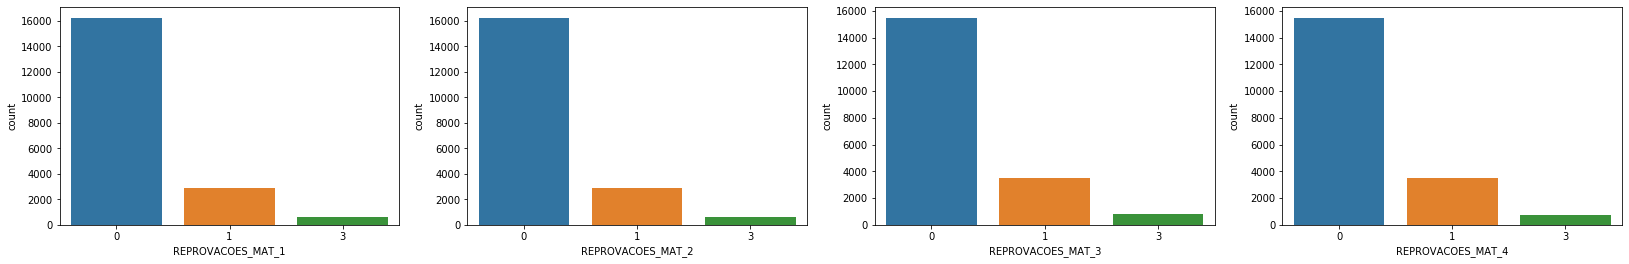

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='REPROVACOES_MAT_1', data=df_data_1)
sns.countplot(ax=axes[1], x='REPROVACOES_MAT_2', data=df_data_1)
sns.countplot(ax=axes[2], x='REPROVACOES_MAT_3', data=df_data_1)
sns.countplot(ax=axes[3], x='REPROVACOES_MAT_4', data=df_data_1)

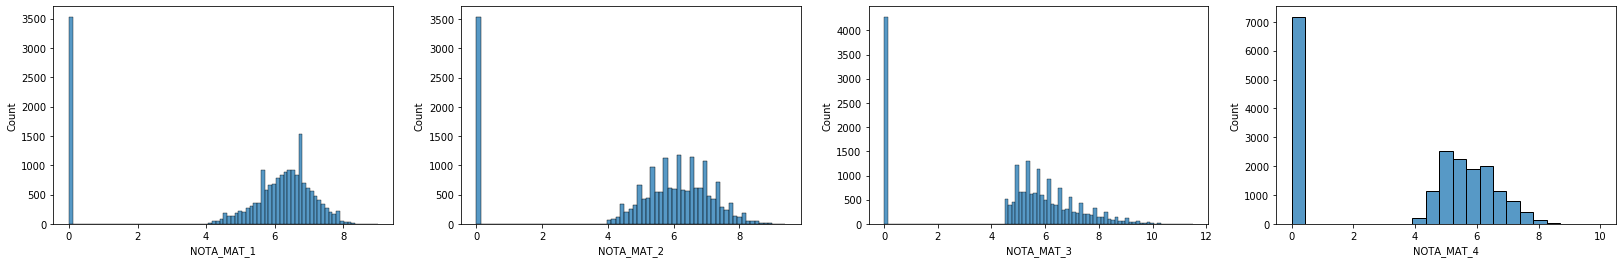

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.histplot(df_data_1['NOTA_MAT_1'], ax=axes[0])
sns.histplot(df_data_1['NOTA_MAT_2'], ax=axes[1])
sns.histplot(df_data_1['NOTA_MAT_3'], ax=axes[2])
sns.histplot(df_data_1['NOTA_MAT_4'].dropna(), ax=axes[3])

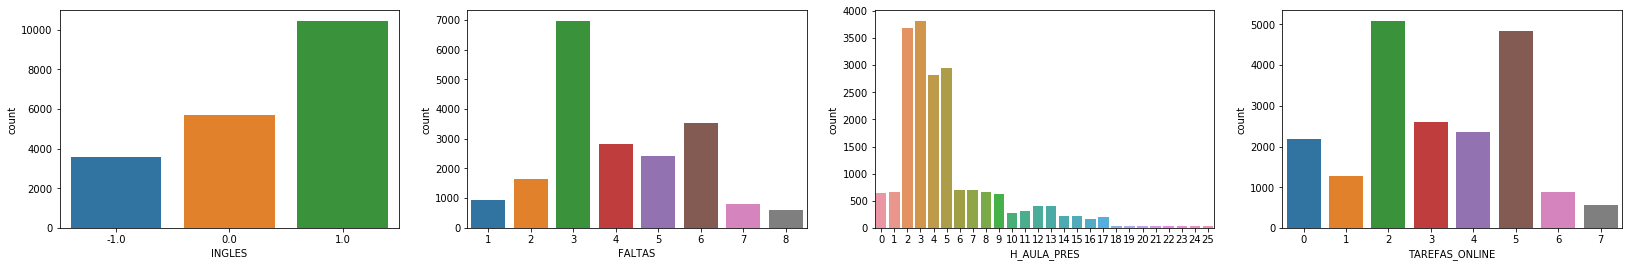

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.countplot(ax=axes[0], x='INGLES', data=df_data_1)
sns.countplot(ax=axes[1], x='FALTAS', data=df_data_1)
sns.countplot(ax=axes[2], x='H_AULA_PRES', data=df_data_1)
sns.countplot(ax=axes[3], x='TAREFAS_ONLINE', data=df_data_1)

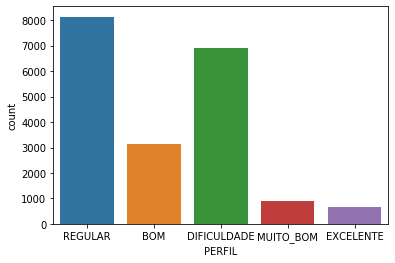

In [42]:
fig = plt.plot()
sns.countplot(x='PERFIL', data=df_data_1)

## ** ATENÇÃO **

Você pode notar pela figura acima que este dataset é desbalanceado, isto é, a quantidade de amostras para cada classe que desejamos classificar é bem discrepante. O participante é livre para adicionar ou remover **LINHAS** no dataset fornecido, inclusive utilizar bibliotecas para balanceamento com ``imblearn``. Entretanto tome **muito cuidado**!!! Você não pode alterar os tipos dos dados e nem remover ou desordenar o dataset fornecido. Todas as operações desse tipo deverão ser feitas por meio de Transforms do scikit-learn :)

<hr>

### Realizando o pré-processamento dos dados

Para o pré-processamento dos dados serão apresentadas duas transformações básicas neste notebook, demonstrando a construção de uma Pipeline com um modelo funcional. Esta Pipeline funcional fornecida deverá ser melhorada pelo participante para que o modelo final alcance a maior acurácia possível, garantindo uma pontuação maior no desafio. Essa melhoria pode ser feita apenas no pré-processamento dos dados, na escolha de um algoritmo para treinamento de modelo diferente, ou até mesmo na alteração do *framework* usado (*scikit-learn*).

A primeira transformação (passo na nossa Pipeline) será a exclusão da coluna "NOME" do nosso dataset, que além de não ser uma variável numérica, também não é uma variável relacionada ao desempenho dos estudantes nas disciplinas. Existem funções prontas no scikit-learn para a realização dessa transformação, entretanto nosso exemplo irá demonstrar como criar uma transformação personalizada do zero no scikit-learn. Se desejado, o participante poderá utilizar esse exemplo para criar outras transformações e adicioná-las à Pipeline final :)

#### Transformação 1: excluindo colunas do dataset

Para a criação de uma transformação de dados personalizada no scikit-learn, é necessária basicamente a criação de uma classe com os métodos ``transform`` e ``fit``. No método transform será executada a lógica da nossa transformação.

Na próxima célula é apresentado o código completo de uma transformação ``DropColumns`` para a remoção de colunas de um DataFrame pandas.

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')

Para aplicar essa transformação em um DataFrame pandas, basta instanciar um objeto *DropColumns* e chamar o método transform().

In [44]:
# Instanciando uma transformação DropColumns
rm_columns = DropColumns(
    columns=["MATRICULA","NOME"]  # Essa transformação recebe como parâmetro uma lista com os nomes das colunas indesejadas
)

print(rm_columns)

DropColumns(columns=['MATRICULA', 'NOME'])


In [45]:
# Visualizando as colunas do dataset original
print("Colunas do dataset original: \n")
print(df_data_1.columns)

Colunas do dataset original: 

Index(['MATRICULA', 'NOME', 'REPROVACOES_MAT_1', 'REPROVACOES_MAT_2',
       'REPROVACOES_MAT_3', 'REPROVACOES_MAT_4', 'NOTA_MAT_1', 'NOTA_MAT_2',
       'NOTA_MAT_3', 'NOTA_MAT_4', 'INGLES', 'H_AULA_PRES', 'TAREFAS_ONLINE',
       'FALTAS', 'PERFIL', 'INGLES_DESC', 'CURSOU_MAT1_DESC',
       'CURSOU_MAT2_DESC', 'CURSOU_MAT3_DESC', 'CURSOU_MAT4_DESC'],
      dtype='object')


In [46]:
# Aplicando a transformação ``DropColumns`` ao conjunto de dados base
rm_columns.fit(X=df_data_1)

# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_data_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_data_1
    ),
)

In [47]:
# Visualizando as colunas do dataset transformado
print("Colunas do dataset após a transformação ``DropColumns``: \n")
print(df_data_2.columns)

Colunas do dataset após a transformação ``DropColumns``: 

Index(['REPROVACOES_MAT_1', 'REPROVACOES_MAT_2', 'REPROVACOES_MAT_3',
       'REPROVACOES_MAT_4', 'NOTA_MAT_1', 'NOTA_MAT_2', 'NOTA_MAT_3',
       'NOTA_MAT_4', 'INGLES', 'H_AULA_PRES', 'TAREFAS_ONLINE', 'FALTAS',
       'PERFIL', 'INGLES_DESC', 'CURSOU_MAT1_DESC', 'CURSOU_MAT2_DESC',
       'CURSOU_MAT3_DESC', 'CURSOU_MAT4_DESC'],
      dtype='object')


Nota-se que a coluna "NOME" foi removida e nosso dataset agora poossui apenas 17 colunas.

#### Transformação 2: tratando dados faltantes

Para tratar os dados faltantes em nosso conjunto de dados, iremos agora utilizar uma transformação pronta da biblioteca scikit-learn, chamada **SimpleImputer**.

Essa transformação permite diversas estratégias para o tratamento de dados faltantes. A documentação oficial pode ser encontrada em: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Neste exemplo iremos simplesmente transformar todos os valores faltantes em zero.

In [48]:
# Criação de um objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
    verbose=0,
    copy=True
)

In [49]:
# Visualizando os dados faltantes do dataset após a primeira transformação (df_data_2)
print("Valores nulos antes da transformação SimpleImputer: \n\n{}\n".format(df_data_2.isnull().sum(axis = 0)))

Valores nulos antes da transformação SimpleImputer: 

REPROVACOES_MAT_1    0
REPROVACOES_MAT_2    0
REPROVACOES_MAT_3    0
REPROVACOES_MAT_4    0
NOTA_MAT_1           0
NOTA_MAT_2           0
NOTA_MAT_3           0
NOTA_MAT_4           0
INGLES               0
H_AULA_PRES          0
TAREFAS_ONLINE       0
FALTAS               0
PERFIL               0
INGLES_DESC          0
CURSOU_MAT1_DESC     0
CURSOU_MAT2_DESC     0
CURSOU_MAT3_DESC     0
CURSOU_MAT4_DESC     0
dtype: int64



In [50]:
# Aplicamos o SimpleImputer ``si`` ao conjunto de dados df_data_2 (resultado da primeira transformação)
si.fit(X=df_data_2)

# Reconstrução de um novo DataFrame Pandas com o conjunto imputado (df_data_3)
df_data_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_data_2
    ),  # o resultado SimpleImputer.transform(<<pandas dataframe>>) é lista de listas
    columns=df_data_2.columns  # as colunas originais devem ser conservadas nessa transformação
)

In [51]:
# Visualizando os dados faltantes do dataset após a segunda transformação (SimpleImputer) (df_data_3)
print("Valores nulos no dataset após a transformação SimpleImputer: \n\n{}\n".format(df_data_3.isnull().sum(axis = 0)))

Valores nulos no dataset após a transformação SimpleImputer: 

REPROVACOES_MAT_1    0
REPROVACOES_MAT_2    0
REPROVACOES_MAT_3    0
REPROVACOES_MAT_4    0
NOTA_MAT_1           0
NOTA_MAT_2           0
NOTA_MAT_3           0
NOTA_MAT_4           0
INGLES               0
H_AULA_PRES          0
TAREFAS_ONLINE       0
FALTAS               0
PERFIL               0
INGLES_DESC          0
CURSOU_MAT1_DESC     0
CURSOU_MAT2_DESC     0
CURSOU_MAT3_DESC     0
CURSOU_MAT4_DESC     0
dtype: int64



Nota-se que não temos mais nenhum valor faltante no nosso conjunto de dados :)

Vale salientar que nem sempre a alteração dos valores faltantes por 0 é a melhor estratégia. O participante é incentivado a estudar e implementar estratégias diferentes de tratamento dos valores faltantes para aprimorar seu modelo e melhorar sua pontuação final.

### Treinando um modelo de classificação

Finalizado o pré-processamento, já temos o conjunto de dados no formato necessário para o treinamento do nosso modelo:

In [52]:
df_data_3.head()

,REPROVACOES_MAT_1,REPROVACOES_MAT_2,REPROVACOES_MAT_3,REPROVACOES_MAT_4,NOTA_MAT_1,NOTA_MAT_2,NOTA_MAT_3,NOTA_MAT_4,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL,INGLES_DESC,CURSOU_MAT1_DESC,CURSOU_MAT2_DESC,CURSOU_MAT3_DESC,CURSOU_MAT4_DESC
0,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,REGULAR,NÃO,APROVADO,APROVADO,APROVADO,APROVADO
1,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,REGULAR,SIM,APROVADO,APROVADO,APROVADO,APROVADO
2,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,BOM,NÃO,APROVADO,APROVADO,APROVADO,APROVADO
3,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE,SIM,REPROVADO,REPROVADO,REPROVADO,REPROVADO
4,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE,SIM,REPROVADO,REPROVADO,REPROVADO,REPROVADO


No exemplo fornecido, iremos utilizar todas as colunas, exceto a coluna **LABELS** como *features* (variáveis de entrada).

A variável **LABELS** será a variável-alvo do modelo, conforme descrito no enunciado do desafio.

#### Definindo as features do modelo [ALTERADO PARA UTILIZAR AS NOVAS COLUNAS]

In [53]:
# transformar_dados : novas colunas para uso no ML

df = df_data_3

# 3) inserir coluna descritiva sobre os alunos que falam ingles, ajustando valores nulos
import numpy as np
df["INGLES"].fillna(-1, inplace = True)

#conditions = [df['INGLES'] > 0, df['INGLES'] == 0, df['INGLES'] < 0]
#choices = ['SIM', 'NÃO', 'SEM RESPOSTA'] # COLUNA COM NOVOS VALORES CRIADOS NESSA ETAPA
#df['INGLES_DESC'] = np.select(conditions, choices)

# 4) eliminar nota ZERO de alunos sem reprovação (ainda não cursaram as matérias 1, 2, 3, 4)
# APROVADO, NOTA >= 4
cond1_mat1 = (df['NOTA_MAT_1'] >= 4) & (df['REPROVACOES_MAT_1'] == 0)
cond1_mat2 = (df['NOTA_MAT_2'] >= 4) & (df['REPROVACOES_MAT_2'] == 0)
cond1_mat3 = (df['NOTA_MAT_3'] >= 4) & (df['REPROVACOES_MAT_3'] == 0)
cond1_mat4 = (df['NOTA_MAT_4'] >= 4) & (df['REPROVACOES_MAT_4'] == 0)
# REPROVADO, NOTA < 4
cond2_mat1 = (df['NOTA_MAT_1'] < 4) & (df['REPROVACOES_MAT_1'] > 0)
cond2_mat2 = (df['NOTA_MAT_2'] < 4) & (df['REPROVACOES_MAT_2'] > 0)
cond2_mat3 = (df['NOTA_MAT_3'] < 4) & (df['REPROVACOES_MAT_3'] > 0)
cond2_mat4 = (df['NOTA_MAT_4'] < 4) & (df['REPROVACOES_MAT_4'] > 0)
# AINDA NAO CURSOU : NOTA = 0, SEM REPROVAÇÕES
cond3_mat1 = (df['NOTA_MAT_1'] == 0) & (df['REPROVACOES_MAT_1'] == 0)
cond3_mat2 = (df['NOTA_MAT_2'] == 0) & (df['REPROVACOES_MAT_2'] == 0)
cond3_mat3 = (df['NOTA_MAT_3'] == 0) & (df['REPROVACOES_MAT_3'] == 0)
cond3_mat4 = (df['NOTA_MAT_4'] == 0) & (df['REPROVACOES_MAT_4'] == 0)
# CONDICOES:
conditions_MAT1 = [cond1_mat1, cond2_mat1, cond3_mat1]
conditions_MAT2 = [cond1_mat2, cond2_mat2, cond3_mat2]
conditions_MAT3 = [cond1_mat3, cond2_mat3, cond3_mat3]
conditions_MAT4 = [cond1_mat4, cond2_mat4, cond3_mat4]

choices = [1, 0, -1] # COLUNA COM NOVOS VALORES CRIADOS NESSA ETAPA
#choices = ['APROVADO', 'REPROVADO', 'AINDA NAO CURSOU'] # COLUNA COM NOVOS VALORES CRIADOS NESSA ETAPA
# CRIANDO NOVAS COLUNAS:
df['CURSOU_MAT1_DESC'] = np.select(conditions_MAT1, choices)
df['CURSOU_MAT2_DESC'] = np.select(conditions_MAT2, choices)
df['CURSOU_MAT3_DESC'] = np.select(conditions_MAT3, choices)
df['CURSOU_MAT4_DESC'] = np.select(conditions_MAT4, choices)

# Definir nota media na materia, caso nao tenha cursado

print(df.NOTA_MAT_1.mean())
print(df.NOTA_MAT_2.mean())
print(df.NOTA_MAT_3.mean())
print(df.NOTA_MAT_4.mean())


# Se 'AINDA NAO CURSOU': recebe a nota média para evitar interferencia nos dados
MEDIA_NOTA_MAT_1 = df.loc[df.CURSOU_MAT1_DESC != -1, 'NOTA_MAT_1'].mean()
MEDIA_NOTA_MAT_2 = df.loc[df.CURSOU_MAT2_DESC != -1, 'NOTA_MAT_2'].mean()
MEDIA_NOTA_MAT_3 = df.loc[df.CURSOU_MAT3_DESC != -1, 'NOTA_MAT_3'].mean()
MEDIA_NOTA_MAT_4 = df.loc[df.CURSOU_MAT4_DESC != -1, 'NOTA_MAT_4'].mean()

print("\n\ncheck\n\n")

# calcula media 'NOTA_MAT' dos aprovados e reprovado
df.loc[df['CURSOU_MAT1_DESC'] == -1, 'NOTA_MAT_1'] = MEDIA_NOTA_MAT_1
df.loc[df['CURSOU_MAT2_DESC'] == -1, 'NOTA_MAT_2'] = MEDIA_NOTA_MAT_2
df.loc[df['CURSOU_MAT3_DESC'] == -1, 'NOTA_MAT_3'] = MEDIA_NOTA_MAT_3
df.loc[df['CURSOU_MAT4_DESC'] == -1, 'NOTA_MAT_4'] = MEDIA_NOTA_MAT_4

print(df.NOTA_MAT_1.mean())
print(df.NOTA_MAT_2.mean())
print(df.NOTA_MAT_3.mean())
print(df.NOTA_MAT_4.mean())

df_data_4 = df

5.197101669195751
5.080202326757714
4.817572078907435
3.6904906423874557


check


5.200521334210659
5.085861859428803
4.818059490084986
4.323614814814815


In [54]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    'REPROVACOES_MAT_1', 'REPROVACOES_MAT_2', "REPROVACOES_MAT_3", "REPROVACOES_MAT_4",
    "NOTA_MAT_1", "NOTA_MAT_2", "NOTA_MAT_3", "NOTA_MAT_4",
    "INGLES", "H_AULA_PRES", "TAREFAS_ONLINE", "FALTAS", 
    #"INGLES_DESC", # somente valores numeros serao usados
    #"CURSOU_MAT1_DESC", "CURSOU_MAT2_DESC", "CURSOU_MAT3_DESC", "CURSOU_MAT4_DESC",
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_data_4[features]
y = df_data_4[target]

O conjunto de entrada (X):

In [55]:
X.head()

,REPROVACOES_MAT_1,REPROVACOES_MAT_2,REPROVACOES_MAT_3,REPROVACOES_MAT_4,NOTA_MAT_1,NOTA_MAT_2,NOTA_MAT_3,NOTA_MAT_4,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
0,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3
1,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3
2,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3
3,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4
4,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5


As variáveis-alvo correspondentes (y):

In [56]:
y.head()

,PERFIL
0,REGULAR
1,REGULAR
2,BOM
3,DIFICULDADE
4,DIFICULDADE


#### Separando o dataset em um conjunto de treino e um conjunto de teste

Iremos separar o dataset fornecido em dois grupos: um para treinar nosso modelo, e outro para testarmos o resultado através de um teste cego. A separação do dataset pode ser feita facilmente com o método *train_test_split()* do scikit-learn:

In [57]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=337)

<hr>

#### Criando um modelo baseado em árvores de decisão

No exemplo fornecido iremos criar um classificador baseado em **árvores de decisão**.

Material teórico sobre árvores de decisão na documentação oficial do scikit-learn: https://scikit-learn.org/stable/modules/tree.html

O primeiro passo é basicamente instanciar um objeto *DecisionTreeClassifier()* da biblioteca scikit-learn.

In [58]:
# Criação de uma árvore de decisão com a biblioteca ``scikit-learn``:
decision_tree = DecisionTreeClassifier()

#### Testando o classificador baseado em árvore de decisão

In [59]:
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
decision_tree.fit(
    X_train,
    y_train
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Execução de predições e avaliação da árvore de decisão

In [60]:
# Realização de teste cego no modelo criado
y_pred = decision_tree.predict(X_test)

In [61]:
X_test.head()

,REPROVACOES_MAT_1,REPROVACOES_MAT_2,REPROVACOES_MAT_3,REPROVACOES_MAT_4,NOTA_MAT_1,NOTA_MAT_2,NOTA_MAT_3,NOTA_MAT_4,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS
6383,0,0,0,0,6.3,5.5,6.8,6.100000,0.0,9,1,6
7341,0,0,0,0,5.7,5.7,5.7,4.323615,-1.0,3,5,4
13531,0,0,3,1,6.2,6.4,0.0,0.000000,0.0,9,0,5
18249,0,0,0,0,6.8,7.7,6.1,7.500000,0.0,25,6,2
10312,0,0,0,0,7.3,7.9,7.9,7.600000,1.0,18,0,1


In [62]:
print(y_pred)

['BOM' 'DIFICULDADE' 'DIFICULDADE' ... 'MUITO_BOM' 'DIFICULDADE' 'REGULAR']


In [63]:
from sklearn.metrics import accuracy_score

# Acurácia alcançada pela árvore de decisão
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Acurácia: 73.0%


<hr>

Neste notebook foi demonstrado como trabalhar com transformações e modelos com a biblioteca scikit-learn. É recomendado que o participante realize seus experimentos editando o código fornecido aqui até que um modelo com acurácia elevada seja alcançado.

Quando você estiver satisfeito com seu modelo, pode passar para a segunda etapa do desafio -- encapsular seu modelo como uma API REST !


In [65]:
# Exporta o modelo matemático gerado para um arquivo:
!pip install joblib --upgrade
from joblib import dump
dump(decision_tree, 'model.joblib')


Defaulting to user installation because normal site-packages is not writeable


['model.joblib']